In [24]:
import pandas as pd
df = pd.read_csv("data\\acfinance.txt", header=None, names=["MG Values"])
print(df)

     MG Values
0    34.269991
1    33.950011
2    33.639991
3    33.249990
4    32.979990
..         ...
795  15.879991
796  15.870000
797  15.570000
798  15.759991
799  15.459990

[800 rows x 1 columns]


In [25]:
import json 

dat = {
    "acfinance.txt": {"name": "ACI-Finance", "tv": "ACIW closing stock prices"},
    "henon.dat.txt": {"name": "Henon", "tv": "Simulated Henon Values"},
    "Lazer.csv": {"name": "Lazer", "tv": "FIR Fluctuation Intensity"},
    "lorenz.dat.txt": {"name": "Lorenz", "tv": "Simulated Lorenz Values"},
    "mackey.dat.txt": {"name": "Mackey-Glass", "tv": "Simulated MG Values"},
    "rossler.dat.txt": {"name": "Rossler", "tv": "Simulated Rossler Values"},
    "sunspot.dat": {"name": "Sunspots", "tv": "Sunspot Count"},  
    "london_merge.csv": {"name": "Bike", "tv": "Bike Share Count"}
}
with open('data\\meta.json', 'w') as file:
    json.dump(dat, file,indent=4)

In [11]:
import json


sesh = {
    "importing" : {
        "dataFile" : "f.csv",
        "targetVar" : 'cnt',
        "featureVars" : ['cnt', 'hum']
    }
}

#rint(json.dumps(sesh))
with open('data.json', 'w') as file:
    json.dump(sesh, file,indent=4)

In [12]:
with open('data.json','r') as file:
    data = json.load(file)

new_element = {
    "preprocessing": {
        "nStepsOut" : 3,
        "nStepsIn" : 5,
        "splitRatio" : 0.7
    }
}
new_element2 = {
    "relevance" : {
        "functionType" : "PCHIP",
        "relValues" : [1,2,3],
        "relPercentiles" : [1,2,3],
        "relThresh" : 0.9,
        "extremesThresh" : 0.5,
        "relCombine" : "first"
    }
}

data.update(new_element)
data.update(new_element2)

with open('data.json', 'w') as file:
    json.dump(data, file, indent=4)

In [17]:
with open('data.json','r') as file:
    data = json.load(file)
print(data['importing'])

{'dataFile': 'f.csv', 'targetVar': 'cnt', 'featureVars': ['cnt', 'hum']}


In [1]:
%matplotlib notebook

import random
from math import sqrt
import numpy as np
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from keras.layers import Flatten
from keras.layers import Conv1D
#from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D
#from keras.layers.convolutional import MaxPooling1D
from tabulate import tabulate
from scipy.special import factorial

from plt_utils import PlotScaledData, PlotRelevance, PlotBins, PlotResampledResults
from evaluator import Evaluator


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [10]:
df1=pd.read_csv("./data/london_merged.csv")
TVAR = 'cnt'
FVARS = [TVAR,'hum'] #FVARS[1:] should always remain as the ordering of feature variables after numpy array conversion
N_FVARS = len(FVARS)

df1=df1.reset_index()[FVARS if TVAR in FVARS else [TVAR] + FVARS] #ensures that TVAR is always the first column
print(df1)

        cnt    hum
0       182   93.0
1       138   93.0
2       134   96.5
3        72  100.0
4        47   93.0
...     ...    ...
17409  1042   81.0
17410   541   81.0
17411   337   78.5
17412   224   76.0
17413   139   76.0

[17414 rows x 2 columns]


In [11]:
#Scaler
df1 = np.array(df1).reshape(-1,N_FVARS)
df1 = df1[:15,:]
#print(df1)

#df1 = np.array([])
#for x in range(10):
#    df1 = np.append(df1,[x**2,x])
#df1 = df1.reshape(-1,2)

scaler=MinMaxScaler(feature_range=(0,1))
df1 = df1.reshape(-1,N_FVARS)
scaled_data = scaler.fit_transform(df1) 
print(f"scaled_data.shape: {scaled_data.shape}")
print(scaled_data)

scaled_data.shape: (15, 2)
[[0.13695871 0.46153846]
 [0.09264854 0.46153846]
 [0.08862034 0.73076923]
 [0.02618328 1.        ]
 [0.00100705 0.46153846]
 [0.         0.46153846]
 [0.00503525 1.        ]
 [0.02920443 1.        ]
 [0.08559919 0.73076923]
 [0.25679758 1.        ]
 [0.48539778 0.46153846]
 [0.6858006  1.        ]
 [0.82175227 0.73076923]
 [0.87613293 0.        ]
 [1.         0.23076923]]


In [12]:
#split data
N_STEPS_IN = 3
N_STEPS_OUT = 2
SPLIT_RATIO = 0.7

def window_frame(df):
    df = DataFrame(df)
    cols, names = list(), list()
    #input sequence (t-n_steps_in, ..., t-1)
    for i in range(N_STEPS_IN, 0, -1):
        cols.append(df.shift(i))
        names+= [f"{FVARS[j]}(t-{i})" for j in range(N_FVARS)]
    #forecast sequence (t, t+1, ..., t+n_steps_out)
    for i in range(0, N_STEPS_OUT):
        cols.append(df[0].shift(-i))
        if i == 0:
            names += [f"{TVAR}(t)"]
        else:
            names += [f"{TVAR}(t+{i})"]
    agg = concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

def get_X_cols(cols):
    return [item for item in cols if "t-" in item]

def get_Y_cols(cols):
    return [item for item in cols if "t-" not in item]
    #def contains_any(string, substrings):
    #    return any(substring in string for substring in substrings)
    #return [item for item in Ys if contains_any(item, targets)]

def split_data(data):
    reframed = window_frame(data)

    training_size = int(reframed.shape[0]*SPLIT_RATIO)
    test_size = reframed.shape[0] - training_size

    train_frame = reframed[:training_size]
    test_frame = reframed[training_size:]

    X_cols = get_X_cols(reframed.columns)
    Y_cols = get_Y_cols(reframed.columns)

    X_train_df = train_frame[X_cols]
    Y_train_df = train_frame[Y_cols]
    X_test_df = test_frame[X_cols]
    Y_test_df = test_frame[Y_cols]

    X_train = X_train_df.values
    X_train = X_train.reshape((X_train.shape[0], N_STEPS_IN, N_FVARS))

    X_test = X_test_df.values
    X_test = X_test.reshape((X_test.shape[0], N_STEPS_IN, N_FVARS))

    Y_train = Y_train_df.values
    Y_train = Y_train.reshape((Y_train.shape[0], N_STEPS_OUT))
    
    Y_test = Y_test_df.values
    Y_test = Y_test.reshape((Y_test.shape[0], N_STEPS_OUT))
    
    k_x = X_train.reshape(X_train.shape[0], N_STEPS_IN*N_FVARS)
    k_x = np.concatenate((k_x,Y_train),axis=1)
    
    return k_x, X_train, Y_train, X_test, Y_test


k_x, X_train, Y_train, X_test, Y_test = split_data(scaled_data)

print(f"X_train: {X_train.shape}")
#print(X_train)
print(f"Y_train: {Y_train.shape}")
#print(Y_train)
print(f"X_test: {X_test.shape}")
#print(X_test)
print(f"Y_test: {Y_test.shape}")
#print(Y_test)
print(f"k_x: {k_x.shape}")
#print(k_x)

X_train: (7, 3, 2)
Y_train: (7, 2)
X_test: (4, 3, 2)
Y_test: (4, 2)
k_x: (7, 8)


In [30]:
#print(k_x[:,:(N_STEPS_IN*N_FVARS)])
kk_x = k_x[:,:(N_STEPS_IN*N_FVARS)] 
#print(kk_x[:-1,0])
var = 1
kmask = np.arange(var, N_FVARS*N_STEPS_IN+var, N_FVARS)
#print(kmask)
print(kk_x[:,kmask])
#print(k_x[:,:(N_STEPS_IN*N_FVARS)].reshape(k_x.shape[0],N_FVARS,N_STEPS_IN))
#print(k_x[:,:(N_STEPS_IN*N_FVARS)].reshape(k_x.shape[0], N_STEPS_IN*N_FVARS // 2, 2).swapaxes(1, 2))


print([arr for arr in kk_x[:,kmask]])

[[0.46153846 0.46153846 0.73076923]
 [0.46153846 0.73076923 1.        ]
 [0.73076923 1.         0.46153846]
 [1.         0.46153846 0.46153846]
 [0.46153846 0.46153846 1.        ]
 [0.46153846 1.         1.        ]
 [1.         1.         0.73076923]]
[array([0.46153846, 0.46153846, 0.73076923]), array([0.46153846, 0.73076923, 1.        ]), array([0.73076923, 1.        , 0.46153846]), array([1.        , 0.46153846, 0.46153846]), array([0.46153846, 0.46153846, 1.        ]), array([0.46153846, 1.        , 1.        ]), array([1.        , 1.        , 0.73076923])]


In [32]:
# when we go to train the forecasting model we will need to convert k_x back to X_train, Y_train
def k_to_XY(k_x):
    X_train = k_x[:,:(N_STEPS_IN*N_FVARS)]
    X_train = X_train.reshape((X_train.shape[0],N_STEPS_IN,N_FVARS))
    Y_train = k_x[:,(N_STEPS_IN*N_FVARS):]
    return kX_train, kY_train

k_x: (12187, 8)


In [ ]:
N_STEPS_IN = 3
N_STEPS_OUT = 2
SPLIT_RATIO = 0.7



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 542 (2.12 KB)
Trainable params: 542 (2.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
381/381 [==============================] - 1s 1ms/step
0.06325791227628866


<IPython.core.display.Javascript object>


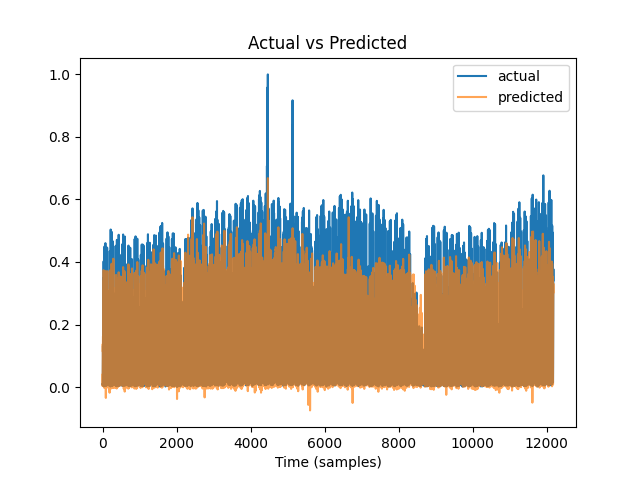

In [12]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)
#train / eval LSTM

hidden = 10
Epochs = 100

#inputs = Input(shape=(N_STEPS_IN,N_FVARS))
#m = LSTM(hidden, activation='relu', return_sequences=True)(inputs)
#m = Dropout(0.2)(m)
#m = LSTM(50)(m)
#m = Dropout(0.2)(m)
#outputA = Dense(N_STEPS_OUT, activation='linear')(m) #one of these for each target variable
#outputB = Dense(N_STEPS_OUT, activation='linear')(m)
#m = Model(inputs=[inputs], outputs=[outputA, outputB])
#m.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(LSTM(hidden, activation='relu', input_shape=(N_STEPS_IN,N_FVARS)))
model.add(Dense(N_STEPS_OUT))
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, Y_train, epochs = Epochs, batch_size=64, verbose=0, shuffle=False)
y_predicttrain = model.predict(X_train)
print(rmse(y_predicttrain.flatten(),Y_train.flatten()))
#y_predicttest = model.predict(X_test)

x_data=np.linspace(0,Y_train.shape[0], num=Y_train.shape[0])
#x_data=np.linspace(0,Y_test.shape[0], num=Y_test.shape[0])
plt.figure()
plt.plot(x_data, Y_train[:,0], label='actual')
plt.plot(x_data, y_predicttrain[:,0], label='predicted', alpha=0.7)  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

164/164 [==============================] - 0s 1ms/step


<IPython.core.display.Javascript object>


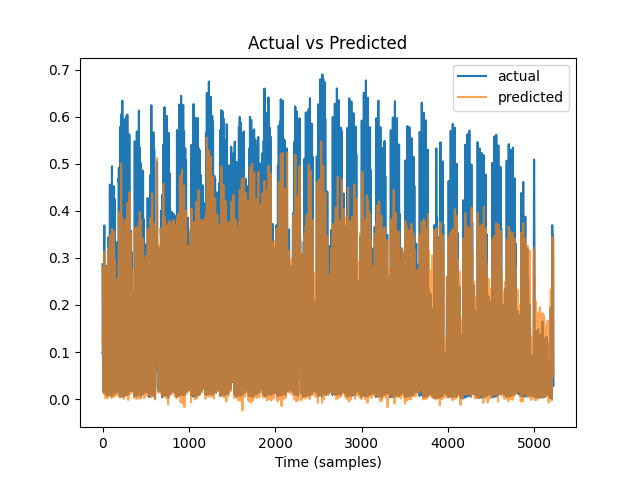

In [15]:
y_predicttest = model.predict(X_test)

x_data=np.linspace(0,Y_test.shape[0], num=Y_test.shape[0])
plt.figure()
plt.plot(x_data, Y_test[:,0], label='actual')
plt.plot(x_data, y_predicttest[:,0], label='predicted', alpha=0.7)  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
#eval

evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'B_max':0.2, 'C_max':0.1, 'm':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {}
                   }

EVALER = Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)
evaler.evaluateMetrics(1, y_predicttrain, y_train, y_predicttest, y_test)

In [139]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
# Generate example data (replace with your own data)
data_length = 100
input_sequence_length = 3
output_sequence_length = 2

# Generate example data (replace with your own data)
A = np.random.rand(data_length)
B = np.random.rand(data_length)
C = np.random.rand(data_length)
A = np.array([])
B = np.array([])
C = np.array([])
for x in range(data_length):
    A = np.append(A,[x*0.01])
    B = np.append(B,[(x*0.01)**2])
    C = np.append(C,[(x*0.01)**3])

# Create input and target sequences
X = []
y = []

for i in range(data_length - input_sequence_length - output_sequence_length + 1):
    X.append(np.column_stack((A[i:i+input_sequence_length], B[i:i+input_sequence_length], C[i:i+input_sequence_length])))
    y.append(np.column_stack((A[i+input_sequence_length:i+input_sequence_length+output_sequence_length], B[i+input_sequence_length:i+input_sequence_length+output_sequence_length])))

X = np.array(X)
y = np.array(y)

#model = Sequential()
#model.add(LSTM(hidden, activation='relu', input_shape=(N_STEPS_IN,N_FVARS)))
#model.add(Dense(N_TVARS*N_STEPS_OUT))
#model.compile(optimizer='adam', loss='mse')
#model.summary()

inputs = Input(shape=(3,3))
m = LSTM(10, activation='relu', return_sequences=True)(inputs)
m = Dropout(0.2)(m)
m = LSTM(10)(m)
m = Dropout(0.2)(m)
outputA = Dense(2, activation='linear')(m)
outputB = Dense(2, activation='linear')(m)
m = Model(inputs=[inputs], outputs=[outputA, outputB])
m.compile(optimizer='adam', loss='mse')
y1 = y[:,:,0]
y2 = y[:,:,1]
m.fit(X,[y1,y2],epochs = 100, batch_size=64, verbose=0, shuffle=False)
input_sequence = X[-1]
predicted_values = m.predict(np.expand_dims(input_sequence, axis=0))
print("Prediction:")
print(predicted_values)
print("True:")
print(y[-1])
'''
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(input_sequence_length, 3), return_sequences=True))
model.add(Dense(4))  # Output layer with 4 units for predicting A and B for 2 time steps each

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Train the model
model.fit(X, y, epochs=50, batch_size=16)

# Now, you can use the trained model for prediction
# Prepare input sequences for prediction
input_sequence = X[-1]  # Use the last input sequence as an example

# Predict the next 2 time steps for variables A and B
predicted_values = model.predict(np.expand_dims(input_sequence, axis=0))

print("Predicted values for A and B for the next 2 time steps:")
print(predicted_values)
'''

1/1 [==============================] - 1s 809ms/step
Prediction:
[array([[0.91659313, 0.9195337 ]], dtype=float32), array([[0.7162984 , 0.66581446]], dtype=float32)]
True:
[[0.98   0.9604]
 [0.99   0.9801]]


'\n# Define the LSTM model\nmodel = Sequential()\nmodel.add(LSTM(64, input_shape=(input_sequence_length, 3), return_sequences=True))\nmodel.add(Dense(4))  # Output layer with 4 units for predicting A and B for 2 time steps each\n\n# Compile the model\nmodel.compile(loss=\'mean_squared_error\', optimizer=Adam(lr=0.001))\n\n# Train the model\nmodel.fit(X, y, epochs=50, batch_size=16)\n\n# Now, you can use the trained model for prediction\n# Prepare input sequences for prediction\ninput_sequence = X[-1]  # Use the last input sequence as an example\n\n# Predict the next 2 time steps for variables A and B\npredicted_values = model.predict(np.expand_dims(input_sequence, axis=0))\n\nprint("Predicted values for A and B for the next 2 time steps:")\nprint(predicted_values)\n'